In [1]:
import numpy as np
import arviz as az
from arviz import ess
# import pymc3 as pm
import pickle
import matplotlib.pyplot as plt
from google.protobuf import text_format
from scipy.stats import multivariate_normal as mvn
from scipy.stats import skewnorm
from scipy.stats import norm
from scipy.interpolate import griddata
from pp_mix.interface import estimate_density_seq
from pp_mix.params_helper import make_default_strauss
import pp_mix.protos.py.params_pb2 as params_pb2


from pp_mix.state import extract_chain
from pp_mix.interface import ConditionalMCMC, RJMCMC, estimate_density_seq, simulate_strauss2d
from pp_mix.utils import loadChains, to_numpy, to_proto
from pp_mix.protos.py.state_pb2 import UnivariateMixtureState, MultivariateMixtureState
from pp_mix.protos.py.params_pb2 import Params, DPPParams, GammaParams

In [2]:
from scipy.stats import dirichlet

true_mu = np.array([-3.5, 3, 0, 6])
true_sigma = np.array([0.8, 0.5, 0.4, 0.5])
w_t = np.array([0.25, 0.25, 0.3, 0.2])

alpha0 = 500
L = 10000
y_t = np.random.choice(len(w_t), size=L, replace=True, p=w_t)
locations = true_mu[y_t] + true_sigma[y_t] * np.random.normal(size=L)
weights = dirichlet.rvs(np.ones(L) * 500 / L)[0, :]
s = 0.25


def f0(x):
    out = np.zeros_like(x)
    for w, l in zip(weights, locations):
        out += w * norm.pdf(x, l, s)
    return out

def generate_data(size):
    clus_alloc = np.random.choice(L, size=size, replace=True, p=weights)
    out = np.random.normal(size=size) * s + locations[clus_alloc]
    return out

(array([ 22.,  62.,  23.,  33., 131.,  15.,  87.,  19.,  68.,  40.]),
 array([-5.62265426, -4.31200308, -3.0013519 , -1.69070072, -0.38004955,
         0.93060163,  2.24125281,  3.55190399,  4.86255517,  6.17320635,
         7.48385753]),
 <a list of 10 Patch objects>)

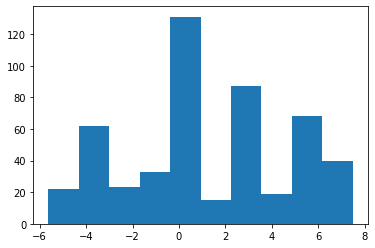

In [3]:
xgrid = np.linspace(-6, 8, 500)
f_eval = f0(xgrid)
data = np.loadtxt("data/data_univ_miller_dunson.txt")
plt.hist(data)

In [77]:
dpp_params = DPPParams(nu=25, rho=4.0, N=50, s=0.5)
prec_params = GammaParams(alpha=1.0, beta=1.0)
rjsampler = RJMCMC(pp_params=dpp_params, 
                 prec_params=prec_params)

gamma_jump_params = params_pb2.GammaParams(alpha=1, beta=1)
cond_sampler = ConditionalMCMC(pp_params=dpp_params, 
                          prec_params=prec_params,
                          jump_params=gamma_jump_params)

ERROR:root:jump_params not recognized


In [89]:
cond_sampler.run(10000, 10000, 1, data)
# rjsampler.run(10000, 10000, 1, data)

Burnin, iter # 200  /  10000
Burnin, iter # 400  /  10000
Burnin, iter # 600  /  10000
Burnin, iter # 800  /  10000
Burnin, iter # 1000  /  10000
Burnin, iter # 1200  /  10000
Burnin, iter # 1400  /  10000
Burnin, iter # 1600  /  10000
Burnin, iter # 1800  /  10000
Burnin, iter # 2000  /  10000
Burnin, iter # 2200  /  10000
Burnin, iter # 2400  /  10000
Burnin, iter # 2600  /  10000
Burnin, iter # 2800  /  10000
Burnin, iter # 3000  /  10000
Burnin, iter # 3200  /  10000
Burnin, iter # 3400  /  10000
Burnin, iter # 3600  /  10000
Burnin, iter # 3800  /  10000
Burnin, iter # 4000  /  10000
Burnin, iter # 4200  /  10000
Burnin, iter # 4400  /  10000
Burnin, iter # 4600  /  10000
Burnin, iter # 4800  /  10000
Burnin, iter # 5000  /  10000
Burnin, iter # 5200  /  10000
Burnin, iter # 5400  /  10000
Burnin, iter # 5600  /  10000
Burnin, iter # 5800  /  10000
Burnin, iter # 6000  /  10000
Burnin, iter # 6200  /  10000
Burnin, iter # 6400  /  10000
Burnin, iter # 6600  /  10000
Burnin, iter #

In [90]:
# cond_sampler.serialize_chains("data/dpp_univ_cond.recordio")
# rjsampler.serialize_chains("data/dpp_univ_rj.recordio")

In [91]:
# rjchains = loadChains("data/dpp_univ_rj.recordio", UnivariateMixtureState)
# condchains = loadChains("data/dpp_univ_cond.recordio", UnivariateMixtureState)

In [92]:
rjchains = rjsampler.chains
condchains = cond_sampler.chains

In [93]:
mtot_rj = np.array([max(x.clus_alloc) + 1 for x in rjchains])
mtot_cond = np.array([x.ma + x.mna for x in condchains])
ma_cond = np.array([x.ma for x in condchains])

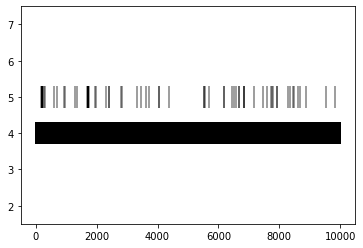

In [94]:
plt.vlines(range(len(mtot_cond)), mtot_cond - 0.3, mtot_cond + 0.3, alpha=0.5)
plt.yticks([2, 3, 4, 5, 6, 7])
plt.ylim(1.5, 7.5)
# plt.savefig("trace_cond.pdf")
plt.show()

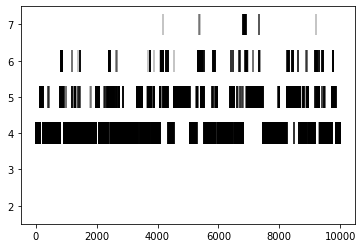

In [95]:
plt.vlines(range(len(mtot_rj)), mtot_rj - 0.3, mtot_rj + 0.3, alpha=0.3)
plt.yticks([2, 3, 4, 5, 6, 7])
plt.ylim(1.5, 7.5)
# plt.savefig("trace_rj.pdf")
plt.show()

In [96]:
print(ess(mtot_rj))
print(ess(mtot_cond))

83.32923323434726
2971.0525822905283


In [97]:
print(np.mean(mtot_cond))
print(np.mean(mtot_rj))
print(np.mean(ma_cond))

4.0076
4.4455
4.0021


## Results:
s = 0.5

rho = 4, nu = 10, ESS Cond = 2020.28, ESS RJ = 60.36, E_m cond = 4.01, E_m RJ = 4.50 E_k cond = 4.005

rho = 4, nu = 25, ESS Cond = 1729.55, ESS RJ = 83.94 E_m cond = 4.006, E_m RJ = 4.47 E_k cond = 4.00

rho = 4, nu = 2.5, ESS Cond = 1630.46, ESS RJ = 112.74 E_m cond = 4.004, E_m RJ = 4.31 E_k cond = 4.00

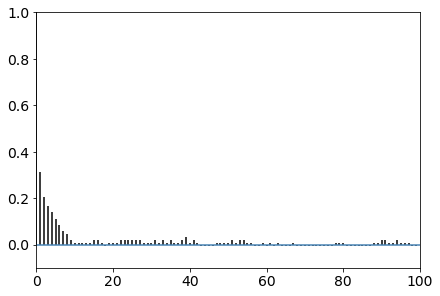

In [98]:
import arviz as az

az.plot_autocorr(mtot_cond)
plt.ylim((-0.1, 1.0))
plt.title("")
# plt.savefig("autocorr_cond.pdf")
plt.show()

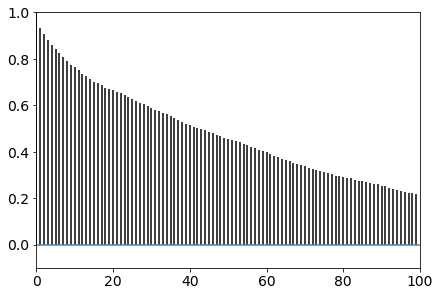

In [99]:
import arviz as az

az.plot_autocorr(mtot_rj)
plt.ylim((-0.1, 1.0))
plt.title("")
# plt.savefig("autocorr_rj.pdf")
plt.show()

In [ ]:
from scipy.special import gamma, loggamma

def phi(k, rho, nu, s):
    d = 1
    tau = np.exp( -0.5*np.log(np.pi) + 1/d*(np.log(rho) + loggamma(d/2+1)) )
    alpha_max = 1/tau*(np.exp(loggamma(d/nu + 1))) ** (1/d)
    return s*np.exp(- (abs(s*alpha_max*k)) ** nu )

def num_clusters(rho, nu):
    phis = []
    for k in range(-1000, 1001):
        phis.append(phi(k, rho, nu))
    
    phis = np.array(phis)
    exp_num = np.sum(phis)
    var_num = np.sum(phis * (1 - phis))
    return exp_num, var_num

In [ ]:
num_clusters(4, 20)

In [ ]:

list(product([1, 2, 3], ["a", "b"]))

In [ ]:
from itertools import product


nus = [10, 100]
ss = [0.25, 0.5, 0.75]

data = np.loadtxt("data/data_univ_miller_dunson.txt")

rho = 4.0

nrep = 10

ess_rj = np.zeros((nrep, len(list(product(nus, ss)))))
ess_cond = np.zeros((nrep, len(list(product(nus, ss)))))
ess_k_cond = np.zeros((nrep, len(list(product(nus, ss)))))

post_m_rj = np.zeros((nrep, len(list(product(nus, ss)))))
post_m_cond = np.zeros((nrep, len(list(product(nus, ss)))))
post_k_cond = np.zeros((nrep, len(list(product(nus, ss)))))


for i in range(nrep):
    print("Running Repetition {0}".format(i+1))
    
    for j, (nu, s) in enumerate(product(nus, ss)):
        print("\r {0} / {1}".format(j+1, ess_rj.shape[1]), flush=True, end=" ")
        np.random.shuffle(data)
        dpp_params = DPPParams(nu=nu, rho=rho, N=50)
        prec_params = GammaParams(alpha=1.0, beta=1.0)

        rjsampler = RJMCMC(pp_params=dpp_params, 
                         prec_params=prec_params)

        gamma_jump_params = params_pb2.GammaParams(alpha=1, beta=1)
        cond_sampler = ConditionalMCMC(pp_params=dpp_params, 
                              prec_params=prec_params,
                              jump_params=gamma_jump_params)


        rjsampler.run(50000, 50000, 5, data, 10000)
        cond_sampler.run(50000, 50000, 5, data, 10000)
        rjchains = rjsampler.chains
        condchains = cond_sampler.chains

        mtot_rj = np.array([max(x.clus_alloc) + 1 for x in rjchains])
        mtot_cond = np.array([x.ma + x.mna for x in condchains])
        ma_cond = np.array([x.ma for x in condchains])

        post_m_rj[i, j] = np.mean(mtot_rj)
        post_m_cond[i, j] = np.mean(mtot_cond)
        post_k_cond[i, j] = np.mean(ma_cond)
    
        ess_rj[i, j] = ess(mtot_rj)
        ess_cond[i, j] = ess(mtot_cond)
        ess_k_cond[i, j] = ess(ma_cond)    

In [ ]:
for i, (nu, s) in enumerate(product(nus, ss)):
    print("nu: {0}, s:{1}, ESS-C: {2:.2f}, ESS-RJ: {3:.2f}".format(
        nu, s, np.median(ess_cond[:, i]), np.median(ess_rj[:, i])))

In [ ]:
mtot_cond

In [ ]:
for i, (nu, s) in enumerate(product(nus, ss)):
    print("nu: {0}, s:{1}, ESS-C: {2:.2f}, ESS-RJ: {3:.2f}".format(nu, s, ess_cond[i], ess_rj[i]))

# print(ess_rj)
# print(ess_cond)

In [ ]:
print(post_m_rj)
print(post_m_cond)
print(post_k_cond)

In [ ]:
dpp_params = DPPParams(nu=100.0, rho=4, N=10)
prec_params = GammaParams(alpha=1.0, beta=1.0)
gamma_jump_params = params_pb2.GammaParams(alpha=1, beta=1)
cond_sampler = ConditionalMCMC(pp_params=dpp_params, 
                          prec_params=prec_params,
                          jump_params=gamma_jump_params)
cond_sampler.run(50000, 50000, 5, data)
condchains = cond_sampler.chains
    
mtot_cond = np.array([x.ma + x.mna for x in condchains])
ma_cond = np.array([x.ma for x in condchains])
ess(mtot_cond)

In [ ]:
plt.vlines(range(len(mtot_cond)), mtot_cond - 0.3, mtot_cond + 0.3, alpha=0.5)
plt.yticks([4, 5])
plt.show()

In [ ]:
ess(mtot_cond)

In [ ]:
az.plot_autocorr(mtot_cond)
plt.ylim((-0.1, 1.0))
plt.title("")
plt.show()